# Binary classification

Recall from our EDA, our plot of the length and angle_from_snout features:


<AxesSubplot:xlabel='length', ylabel='angle_from_snout'>

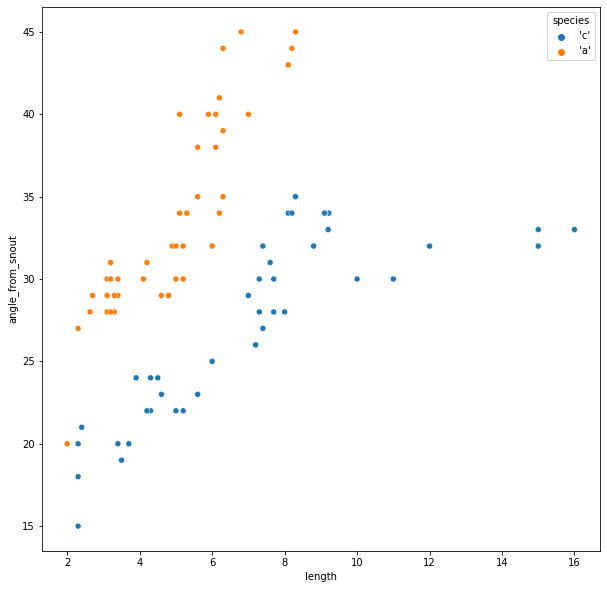

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import pseudo data set
df = pd.read_csv('../../data/tabular/croc-aligator.csv')
training_data = pd.DataFrame({'length': df.length, 'angle_from_snout': df.angle_from_snout}).to_numpy()

# Map crocs, alligators to (-1,1) for classification
species =  pd.factorize(df.species)
vfunc = np.vectorize(lambda t: -1 if t == 0 else 1)
labels = vfunc(species[0])

#Visualize the data
_, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=df, x="length", y='angle_from_snout', hue='species', legend='full')



## Choosing a model

Given our two features, how can we come up with a function $f$ that allows us to distinguish between crocs and alligators? Formally we want:
$f: \mathbb{R}^2 \rightarrow \{\text{alligator},\text{crocodile}\}$.

Well, if we look at the figure above, it seems like almost all points in that space can be separated by a slanted line anywhere around $20<y<25$. This seems like a reasonable thing to do,
if we were to draw a line in between the orange and blue points, we could claim that any point that falls above the line is an alligator and any point
that falls below the line is a crocodile.

Let us proceed with this discriminative line of reasoning.  So our task now is to come up with an equation for a line.
By visual inspection it looks like we have a slope of 1.5 and an intercept of 21. Let's see what this line looks like
over-laid on our scatter graph.


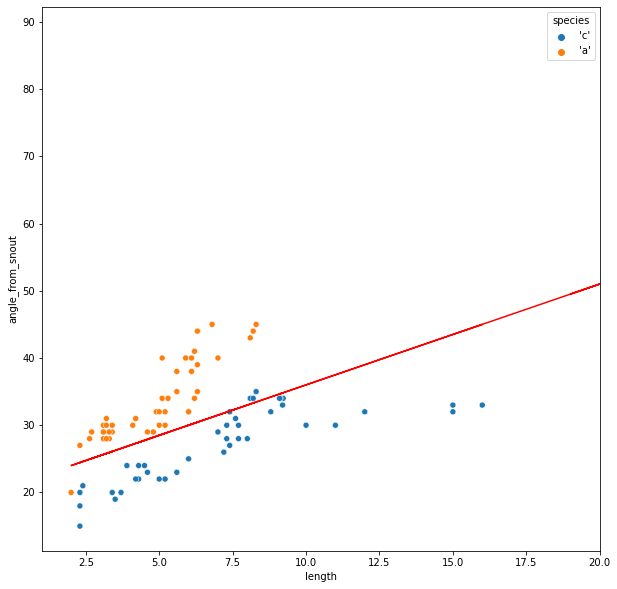

In [2]:
def eq_of_line(x) -> int:
    return 1.5*x + 21

eq_of_line_vec = np.vectorize(eq_of_line)

_, ax = plt.subplots(figsize=(10,10))
scatter = sns.scatterplot(data=df, x="length", y='angle_from_snout', hue='species', legend='full', ax=ax)
ax.set_xlim(1, 20)
scatter.plot(training_data, eq_of_line_vec(training_data), color='r',  )



### Linear Algebra

Okay, so we've come up with a line, but our task isn't quite complete, we still don't have an $f$ that classifies our data.
What we need is to somehow use our line to classify a point in feature space. The answer lies in an operation from linear algebra.


#### Vector space

We must first realize that the space in which is our features live in (aka feature space) is $\mathbb{R}^2$. It is perfectly reasonable to
treat every feature we have in $\mathbb{R}^2$ as vector. And therefore, we will treat $\mathbb{R}^2$ as a vector space over the reals, and we will
also consider the dot product and norm in this space as well. By allowing all this additional structure on our vector space, we will soon
see how we can leverage this features in useful ways.


#### Perpendicular vectors

Let us examine the equation of a line $2x + y = 0$ and use the following set of images to gain some intuition.

![alt text](../../images/perpendicular.png "Title")

An important result in linear algebra is that two vectors $a,b$ are perpendicular if their dot product is 0:

$a \cdot b = 0$.

Well algebraically if we take our equation of our line and re-write it like so:

$2x +y  =  \langle{2,1}\rangle * \langle{x,y}\rangle  = 0$

We can see some vectors popping out of our equation. That is $\langle{2,1}\rangle$ becomes a perpendicular vector to our line,
and any \langle{x,y}\rangle vector is represneted by our line.

Re-writing our equation in standard form allows us to easily read off this perpendicular vector.

$2x +y  = * \langle{2,1}\rangle = 0$

#### Dot products as a classification tool

![alt text](../../images/perpendicular-2.png "Title")

If we observe the diagram above and take the dot products of all the vectors relative to the normal vector, you will notice:

- Feature vectors that are below the line are negative
- Feature vectors that are above the line are positive

This is a very handy result. We can use the dot product to determine if our feature vectors are classified correctly!

The dot product between our normal vector and a feature vector can be represented as:

$\theta_1*x_1^{(i)} + \theta_2*x_2^{(i)}  + \theta_0 $ or more compactly $\theta \cdot x^{(i)} + \theta_0$.

And so :

$\theta \cdot x^{(i)} > 0$ means that the feature vectors are above the line
$\theta \cdot x^{(i)} < 0$ means the feature vectors are below the line
$\theta \cdot x^{(i)} = 0$ means the feature vectors are on the line


### Final model

Okay, it seems like we finally have a way to model our problem!

We need to find the equation of a line, compute the dot product of our normal vector a feature vector, and then map the sign
of the dot product to an alligator or crocodile!

If we let $\text{alligator} = 1$ and $\text{crocodile} = -1$ , then we finally have a rule for $f$. Let
the output of $f$ be $\hat y$ where  $\hat y = \text{sign}(\theta \cdot x^{(i)})$



### Evaluating our model

Like every model, we need a way to quantify how correct or incorrect it is. For our purposes we will focus on quantifying incorrectness.
Thankfully we can use leverage the dot product again to help us.

#### Dot products as a similarity tool

Aside from returning a negative / positive value that we can use for classification, the dot product can be used to quantify 'similarity'.

How?

If we fix two feature vectors of the same magnitude, the feature vector that is closest to the normal vector will have the larger dot product.
This is a very useful property. In other words, this tells us that feature vectors that point in the same direction as normal vectors are the most similar.
And vectors that point in the opposite direction are the most dissimilar (larger negative dot product).

Recall that we use loss functions to associate a 'cost' to a model. So one thing we could do is

- Allow all correct values to have no loss
- Use the negative value of the dot product to represent dissimilarity

This rule can be represented as $l = \text{max}(0,1-\theta \cdot x^{(i)})$. Notice that we removed our $\text{sign}()$ so we fully capture how
dissimilar two vectors are. This type of loss function is called hinge loss.

So are full loss function, with our model is now:

$
\text{avg loss}  = \frac{1}{n} \sum\limits_{i=0}^{n}
    \text{max}(0,1-\theta \cdot x^{(i)})
$


It is also worth noting that the magnitude affects the dot product. That is if we fix two feature vectors at the same angle, the length of the
larger feature vector will yield a higher dot product (with the normal vector). So really the most dissimilar vector we could have, is
a vector that is 180 degrees away from a normal vector and with a very large magnitude.



